# Import necessary libraries

In [59]:
import pandas as pd
import numpy as np
import missingno as msno
from geopy.geocoders import Nominatim
from fuzzywuzzy import fuzz
from datetime import datetime
import yagmail
import plotly
import plotly.express as px

# Read the CSV file into a Pandas DataFrame

In [60]:
df = pd.read_csv("Airbnb_Open_Data.csv", low_memory=False)

# Convert column names to lowercase and replace spaces with underscores

In [61]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
column_names = df.columns.tolist()
column_names

['id',
 'name',
 'host_id',
 'host_identity_verified',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'lat',
 'long',
 'country',
 'country_code',
 'instant_bookable',
 'cancellation_policy',
 'room_type',
 'construction_year',
 'price',
 'service_fee',
 'minimum_nights',
 'number_of_reviews',
 'last_review',
 'reviews_per_month',
 'review_rate_number',
 'calculated_host_listings_count',
 'availability_365',
 'house_rules',
 'license']


# Change the name of column from availability 365 to days_booked

In [62]:
df.rename(columns={'availability_365': 'days_booked'}, inplace=True)
print("Column renamed from 'availability 365' to 'days_booked'.")

Column renamed from 'availability 365' to 'days_booked'.


# Visualize missing Value

In [63]:
missing_values = df.isnull().sum()
print(missing_values)

id                                     0
name                                 250
host_id                                0
host_identity_verified               291
host_name                            411
neighbourhood_group                   29
neighbourhood                         16
lat                                    8
long                                   8
country                              533
country_code                         136
instant_bookable                     110
cancellation_policy                   76
room_type                              0
construction_year                    214
price                                248
service_fee                          274
minimum_nights                       409
number_of_reviews                    183
last_review                        15893
reviews_per_month                  15879
review_rate_number                   326
calculated_host_listings_count       319
days_booked                          448
house_rules     

# Visualize missing values using missingno library

<AxesSubplot:>

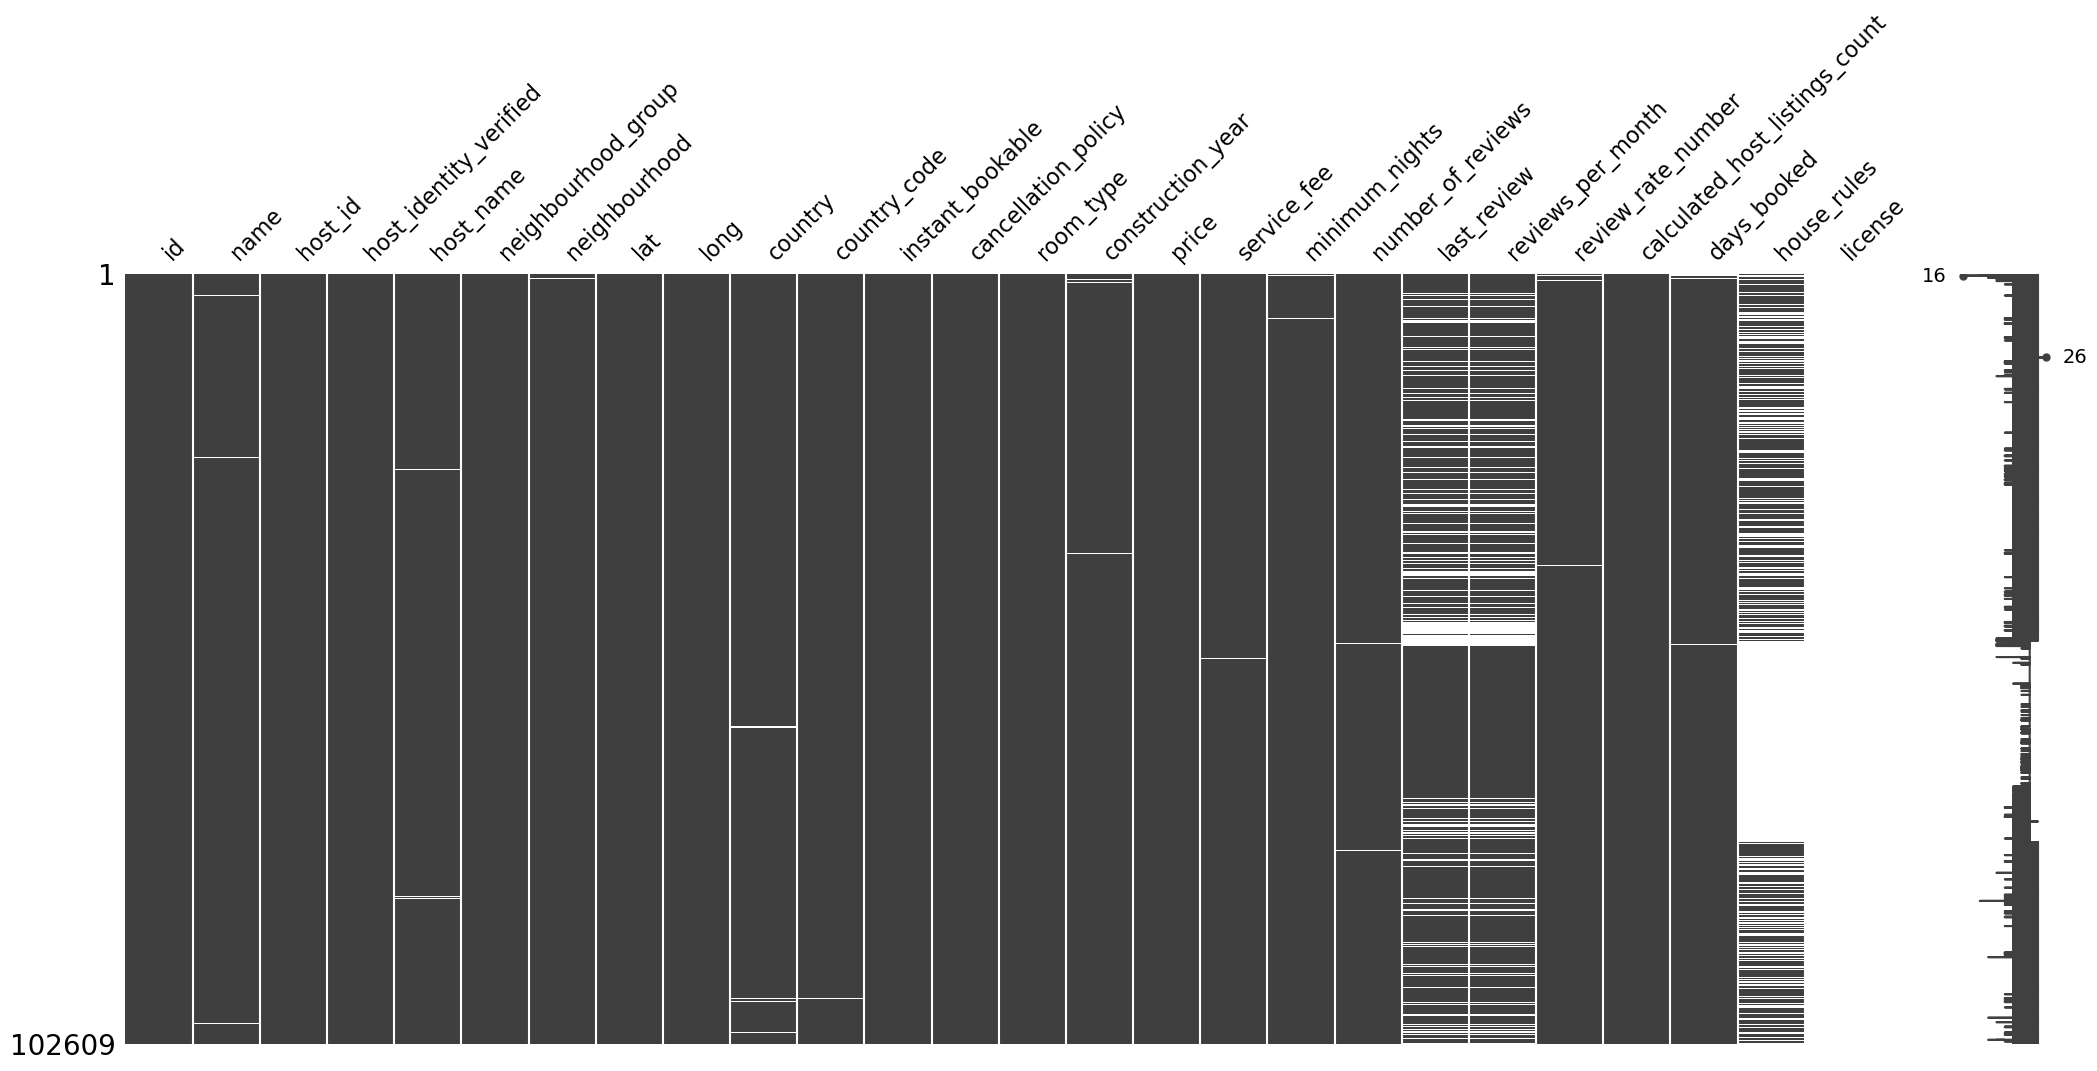

In [64]:
msno.matrix(df)

# Display the first few rows of the DataFrame

In [65]:
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,NaN,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,NaN,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


# Display information about the DataFrame

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102609 entries, 0 to 102608
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102609 non-null  int64  
 1   name                            102359 non-null  object 
 2   host_id                         102609 non-null  int64  
 3   host_identity_verified          102318 non-null  object 
 4   host_name                       102198 non-null  object 
 5   neighbourhood_group             102580 non-null  object 
 6   neighbourhood                   102593 non-null  object 
 7   lat                             102601 non-null  float64
 8   long                            102601 non-null  float64
 9   country                         102076 non-null  object 
 10  country_code                    102473 non-null  object 
 11  instant_bookable                102499 non-null  object 
 12  cancellation_pol

# Get the shape of the dataset (number of rows and columns)

In [67]:
df.shape

(102609, 26)

# Remove the 'license' column

In [68]:
df.drop(columns=['license'], inplace=True)


# Remove duplicate lines

In [69]:
duplicates = df.duplicated().sum()
df.drop_duplicates(inplace=True)
print("Number of duplicated column =",duplicates)

Number of duplicated column = 551


# Get the shape of the dataset (number of rows and columns)

In [70]:
df.shape

(102058, 25)

# Function to update country code based on the country name


In [71]:
def update_country_code(row):
    if row['country'] == 'United States':
        return 'US'
    else:
        return row['country_code']

# Apply the function to update the country code column
df['country_code'] = df.apply(update_country_code, axis=1)

# Remove the 'lat', 'long' ,reviews_per_month,number_of_reviews,calculated_host_listings_count,host_id,price ,service_fee, host_name who are null and save them in new file

In [72]:
# Filter rows where 'lat' or 'long' is None or NaN
rows_to_check = df[df['lat'].isnull() | df['long'].isnull()| df['review_rate_number'].isnull()| df['reviews_per_month'].isnull()| df['last_review'].isnull()| df['number_of_reviews'].isnull()| df['calculated_host_listings_count'].isnull()| df['host_id'].isnull()|df['price'].isnull() & df['service_fee'].isnull()| df['host_name'].isnull()]

# Delete rows with missing lat or long values from the original DataFrame
df.dropna(subset=['host_id','host_name','lat', 'long','review_rate_number','reviews_per_month','last_review','number_of_reviews','calculated_host_listings_count'], inplace=True)
# Get the current date in the required format (DD_MM_YYYY)
current_date = datetime.now().strftime("%d_%m_%Y")
rows_to_check.to_csv(f'need_to_check_{current_date}.csv', index=False)

# sending email to agent who is responsable of Geopositioning to correct mistakes

In [38]:
def send_email():
    sender_email = 'xxxxx@gmail.com'
    sender_password = 'jhgjhj'
    receiver_email = 'xxxx@gmail.com'
    current_date = datetime.now().strftime("%d_%m_%Y")

    yag = yagmail.SMTP(sender_email, sender_password)
    
    file_path = f'need_to_check_{current_date}.csv'
    subject = f"CSV File - {current_date}"
    body = "Please find the attached CSV file and you need to check lat,long,reviews_per_month,number_of_reviews,calculated_host_listings_count,host_id,price ,service_fee, host_name who are null you should to check them"

    yag.send(
        to=receiver_email,
        subject=subject,
        contents=body,
        attachments=file_path,
    )

send_email()

KeyboardInterrupt: 

# Define a function to find the most similar neighbourhood group

In [73]:
def find_neighbourhood_group(neighbourhood):
    # Filter the dataframe for non-empty 'neighbourhood group' values
    filtered_data = df[df['neighbourhood_group'].notnull()]
    
    # Calculate similarity scores between the given neighbourhood and existing neighbourhoods
    similarity_scores = filtered_data['neighbourhood'].apply(lambda x: fuzz.ratio(str(x).lower(), str(neighbourhood).lower()))
    
    # Find the index of the most similar neighbourhood
    max_similarity_index = similarity_scores.idxmax()
    
    # Return the corresponding 'neighbourhood group' value
    return df.loc[max_similarity_index, 'neighbourhood_group']

# Fill missing 'neighbourhood group' values based on 'neighbourhood'
df['neighbourhood_group'] = df.apply(
    lambda row: find_neighbourhood_group(row['neighbourhood']) if pd.isnull(row['neighbourhood_group']) else row['neighbourhood_group'],
    axis=1
)

# adding code country using geopy

In [74]:
# Initialize geopy
geolocator = Nominatim(user_agent="geoapiExercises")

# Function to get location details using latitude and longitude
def get_location_details(lat, long):
    location = geolocator.reverse((lat, long), language='en', exactly_one=True)
    if location is not None:
        address = location.raw.get('address', {})
        country_code = address.get('country_code', None)
        country = address.get('country', None)
        city = address.get('city', None)
        return country_code, county, city
    return None, None, None

# Iterate through the rows and fill missing country code, county, and city
for index, row in df.iterrows():
    if pd.isnull(row['country_code']) or pd.isnull(row['country']) or pd.isnull(row['neighbourhood_group']):
        lat = row['lat']
        long = row['long']
        country_code, county, city = get_location_details(lat, long)
        
        # Update country code, county, and city in the DataFrame
        country_code = country_code.upper()
        df.at[index, 'country_code'] = country_code
        df.at[index, 'country'] = county
        df.at[index, 'neighbourhood_group'] = city

# Fill empty 'house_rules' column with specified text

In [75]:
df['house_rules'] = df['house_rules'].fillna('You should respect our rules mentioned in Airbnb')

# Fill empty 'days_booked' column with 0

In [76]:
df['days_booked'].fillna('0', inplace=True)

# Fill missing values in 'host_identity_verified' column with 'unconfirmed'

In [77]:
df['host_identity_verified'].fillna('unconfirmed', inplace=True)

# Function to check and update the 'name' column

In [78]:
def update_name(row):
    if pd.isnull(row['name']) or isinstance(row['name'], int):
        return row['room_type']+" for location"
    else:
        return row['name']

# Apply the function to update the 'NAME' column
df['name'] = df.apply(update_name, axis=1)

# Fill missing 'host_name' values with 'host_id'

In [79]:
df['host_name'].fillna(df['host_id'], inplace=True)

# Fill missing 'instant_bookable' values with 'FALSE'

In [80]:
df['instant_bookable'].fillna('FALSE', inplace=True)

# Fill missing 'cancellation_policy' values with 'flexible'

In [81]:
df['cancellation_policy'].fillna('flexible', inplace=True)

# Fill missing 'construction_year' values with '1900'

In [82]:
df['construction_year'].fillna('1900', inplace=True)
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,NaN,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$142,NaN,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
3,1002755,Entire home/apt for location,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$368,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,You should respect our rules mentioned in Airbnb
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$204,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th..."
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,$577,$115,3.0,74.0,6/22/2019,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs."


# Apply the cleaning function to 'price' and 'service fee' columns removing sepcial charachter

In [83]:
def clean_currency(column):
    return column.replace({'\$': '', ',': ''}, regex=True).astype(float)

df['price'] = clean_currency(df['price'])
df['service_fee'] = clean_currency(df['service_fee'])
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,NaN,193.0,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,142.0,NaN,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
3,1002755,Entire home/apt for location,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,368.0,74.0,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,You should respect our rules mentioned in Airbnb
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,204.0,41.0,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th..."
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,577.0,115.0,3.0,74.0,6/22/2019,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs."


# adding fees service

In [84]:
df['service_fee'] = df.apply(lambda row: row['price'] * 0.18 + 2 if pd.isnull(row['service_fee']) else row['service_fee'], axis=1)
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,NaN,193.00,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,142.0,27.56,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
3,1002755,Entire home/apt for location,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,368.0,74.00,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,You should respect our rules mentioned in Airbnb
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,204.0,41.00,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th..."
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,577.0,115.00,3.0,74.0,6/22/2019,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs."


# adding price

In [85]:
df['price'] = df.apply(lambda row: row['service_fee'] / 0.12 - 2 if pd.isnull(row['price']) else row['price'], axis=1)
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,1606.333333,193.00,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,142.000000,27.56,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
3,1002755,Entire home/apt for location,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,368.000000,74.00,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,You should respect our rules mentioned in Airbnb
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,204.000000,41.00,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th..."
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,577.000000,115.00,3.0,74.0,6/22/2019,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs."


# Round 'price' column values to integers

In [86]:
def round_float_to_int(column):
    return column.replace([np.inf, -np.inf], np.nan).fillna(0).astype(float).apply(np.floor).astype(int)

df['price'] = round_float_to_int(df['price'])
df['service_fee'] = round_float_to_int(df['service_fee'])
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,1606,193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,142,27,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
3,1002755,Entire home/apt for location,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,368,74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,You should respect our rules mentioned in Airbnb
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,204,41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th..."
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,577,115,3.0,74.0,6/22/2019,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs."


# Fill missing 'minimum nights' values with default '1 night'

In [87]:
df['minimum_nights'].fillna('1', inplace=True)


<AxesSubplot:>

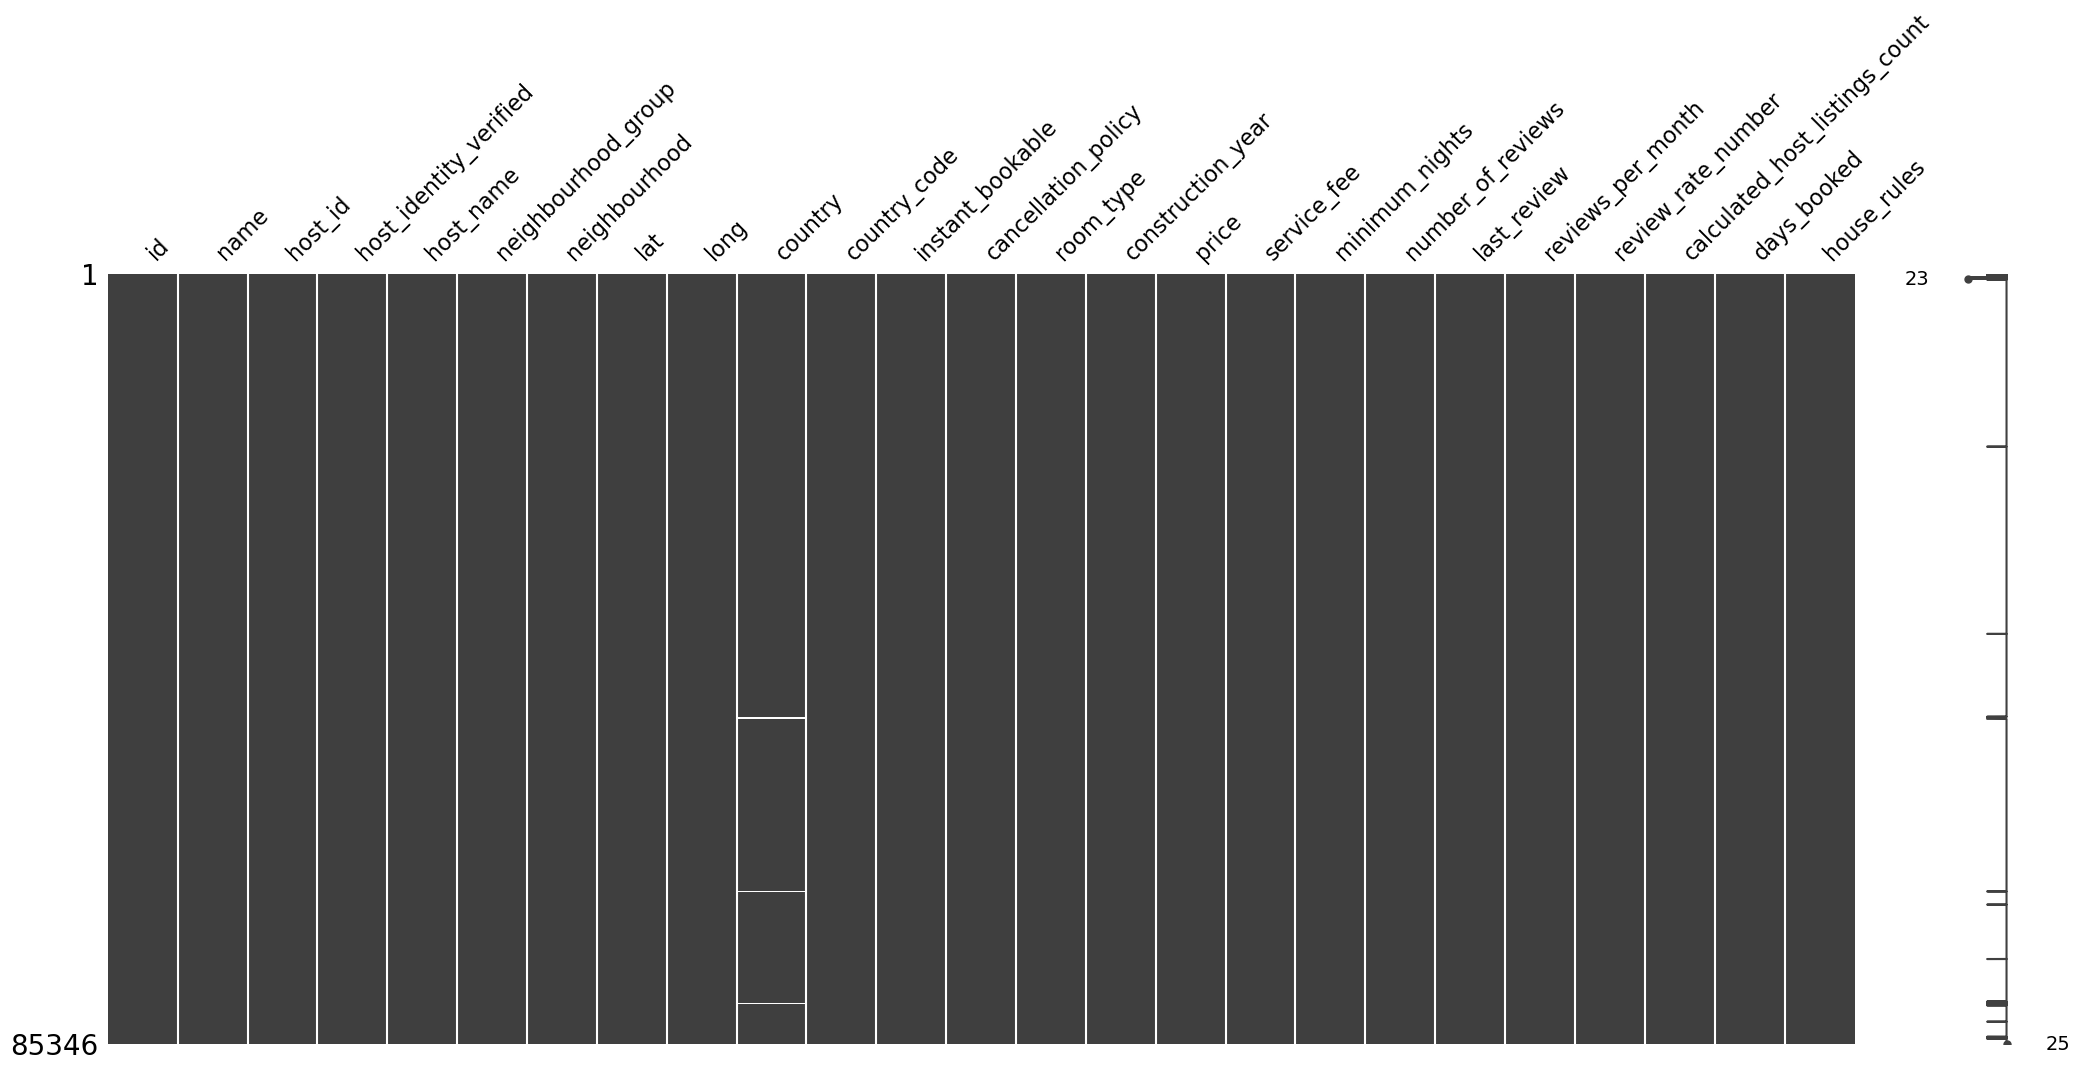

In [88]:
msno.matrix(df)

# Display the first 5 rows of the cleaned DataFrame

In [89]:
df.head()

,id,name,host_id,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,...,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,days_booked,house_rules
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,1606,193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,142,27,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...
3,1002755,Entire home/apt for location,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,368,74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,You should respect our rules mentioned in Airbnb
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,204,41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th..."
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,...,577,115,3.0,74.0,6/22/2019,0.59,3.0,1.0,374.0,"No smoking, please, and no drugs."


In [90]:
missing_values = df.isnull().sum()
print(missing_values)

id                                  0
name                                0
host_id                             0
host_identity_verified              0
host_name                           0
neighbourhood_group                 0
neighbourhood                      16
lat                                 0
long                                0
country                           487
country_code                        0
instant_bookable                    0
cancellation_policy                 0
room_type                           0
construction_year                   0
price                               0
service_fee                         0
minimum_nights                      0
number_of_reviews                   0
last_review                         0
reviews_per_month                   0
review_rate_number                  0
calculated_host_listings_count      0
days_booked                         0
house_rules                         0
dtype: int64


# Specify the path where you want to save the Excel file

In [91]:
output_file_path = "C://Users/AI-MHT/Desktop/data/datafinal/Cleaned_Airbnb_Dataxwx.xlsx"

# Save the cleaned DataFrame to an Excel file

In [92]:
# df.to_excel(output_file_path, index=False)
df.to_csv(output_file_path, index=False)

print(f"Data has been saved to '{output_file_path}'.")


Data has been saved to 'C://Users/AI-MHT/Desktop/data/datafinal/Cleaned_Airbnb_Dataxwx.xlsx'.


# create new DataFrame named first_location_df and has columns 'lat', 'long', and 'neighbourhood'

In [93]:
# Group by 'neighbourhood' and get the first latitude and longitude for each group
first_location_df = df.groupby('neighbourhood').agg({'lat': 'first', 'long': 'first'}).reset_index()

# Merge with the neighborhood counts DataFrame
first_location_df = pd.merge(
    first_location_df,
    df['neighbourhood'].value_counts().reset_index().rename(columns={'neighbourhood': 'neighborhood_counts'}),
    how='left',
    left_on='neighbourhood',
    right_on='index'
).drop(columns='index')

# Display the result
print("First latitude and longitude for each neighbourhood with counts:")
print(first_location_df)

First latitude and longitude for each neighbourhood with counts:
       neighbourhood       lat      long  neighborhood_counts
0           Allerton  40.86466 -73.85709                   88
1      Arden Heights  40.56033 -74.18259                    9
2           Arrochar  40.59251 -74.06479                   49
3            Arverne  40.59783 -73.80158                  200
4            Astoria  40.75384 -73.91433                 1561
..               ...       ...       ...                  ...
218  Windsor Terrace  40.65599 -73.97519                  280
219        Woodhaven  40.68968 -73.85219                  163
220         Woodlawn  40.89747 -73.86390                   29
221          Woodrow  40.53777 -74.20674                    1
222         Woodside  40.74409 -73.91122                  494

[223 rows x 4 columns]


# visualize on the maps

In [99]:
fig = px.scatter_geo(
    first_location_df,
    lat='lat',
    lon='long',
    hover_name='neighbourhood',
    size='neighborhood_counts',  
    title='Maps with all details'
)

# Show the map
fig.show()

In [100]:
fig.update_geos(center=dict(lon=-73.85709, lat=40.86466), 
               projection_scale=300)
fig.show()

In [96]:
plotly.offline.plot(fig, filename=r'maps.html', auto_open=True)


'maps.html'